### Try COLAB

In [472]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch

# Import

In [473]:
import torch
from torch import nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence # for padding data

import pandas as pd # for making csv file

from sklearn.metrics import accuracy_score, f1_score

import wandb

import seaborn as sns
import matplotlib.pyplot as plt

import random


### CUDA

In [474]:
# GPU Support?
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device('cuda')
else:
    print("Using the CPU")
    device = torch.device('cpu')

Using the GPU


# Generate Dataset

In [475]:
# Generate a dataset of sequences containing characters 'a', 'b', and 'c' in order
def gen_data(N=100, min_len=3, max_len=20) -> list:
    """Generates a dataset of sequences containing characters 'a', 'b', and 'c' in order.
    Parameters: N: int, number of sequences to generate
                min_len: int, minimum length of a sequence
                max_len: int, maximum length of a sequence
    Returns: list of strings, each string is a sequence of characters 'a', 'b', and 'c' in order"""
    dataset = []
    max_member = max_len // 3 # three times this number is less than max_len
    min_member = min_len // 3 # three times this number is less than min_len
    if min_len < 3:
        min_len = 3
        print("Minimum length must be at least 3. Setting min_len to 3.")
    if max_len > 1000:
        max_len = 1000
        print("Maximum length must be at most 1000. Setting max_len to 1000.")

    for n in range(N):
        if n % 2 == 2: # 50% of the time add actual member of formal language family
            length = random.randint(min_member, max_member)
            sequence = 'a' * length + 'b' * length + 'c' * length
            dataset.append(sequence)
        else:
            length = random.randint(min_len-3, max_len-3)  # Random sequence length between 3 and (20-3 = 17). 3 is the smallest possible length for a sequence to be in the language
            counts = [1, 1, 1] # Initialize counts for 'a', 'b', and 'c'. Will have at least one of each letter.

            # Distribute the length among a, b, and c
            for i in range(length):
                counts[random.randint(0, 2)] += 1

            # Ensure alphabetical order and create the sequence
            sequence = 'a' * counts[0] + 'b' * counts[1] + 'c' * counts[2]
            dataset.append(sequence)
    return dataset

### Functions for labels and encoding

In [476]:
# Get labels
def get_labels(data):
    y = torch.zeros(len(data))
    for i, sequence in enumerate(data):
        if sequence == 'a'*(len(sequence)//3) + 'b'*(len(sequence)//3) + 'c'*(len(sequence)//3):
            y[i] = 1
    return y

In [477]:
# Create a one-hot encoding of the sequences and a labels tensor
def one_hot_encode(sequence):
    encoded = torch.zeros(len(sequence), 3)
    for i, char in enumerate(sequence):
        encoded[i, 'abc'.index(char)] = 1
    return encoded

## One-Hot Encoding

In [478]:
def get_dataset(N, min_len=3, max_len=20, split=False):
    """
    Generates a dataset of sequences containing characters 'a', 'b', and 'c' in order.
    One-hot encodes, pads, and creates labels for the dataset.
    Parameters: N: int, number of sequences to generate
                min_len: int, minimum length of a sequence
                max_len: int, maximum length of a sequence
                split: bool, whether to split the dataset into train and test sets
    Returrns: TensorDataset, list of sequencese if split=False
                Tuple(TensorDataset, TensorDataset), list of sequences if split=True
    """
    sequences = gen_data(N, min_len, max_len)
    length_tensor = torch.tensor([len(s) for s in sequences])
    # check if there are any lengths that are 0 or less
    if torch.any(length_tensor <= 0):
        print("There are sequences with length 0 or less. Removing them.")
        sequences = [s for s in sequences if len(s) > 0]
        length_tensor = torch.tensor([len(s) for s in sequences])
    encoded_sequences = [one_hot_encode(sequence) for sequence in sequences]
    padded_sequences = pad_sequence(encoded_sequences, batch_first=True)
    y = get_labels(sequences)
    if split: # split into train and test sets
        train_size = int(0.8 * N) # 80/20 train/test split
        train_dataset = padded_sequences[:train_size]
        test_dataset = padded_sequences[train_size:]
        train_lengths = length_tensor[:train_size]
        test_lengths = length_tensor[train_size:]
        train_y = y[:train_size]
        test_y = y[train_size:]
        train_dataset = TensorDataset(train_dataset, train_y, train_lengths)
        test_dataset = TensorDataset(test_dataset, test_y, test_lengths)
        return train_dataset, test_dataset, sequences
    dataset = TensorDataset(padded_sequences, y, length_tensor)
    return dataset, sequences

In [479]:
train_dataset, test_dataset, sequences = get_dataset(100, 3, 20, split=True)

In [480]:

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# RNN Model

In [481]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_length, seq_length, input_size/vocab_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input, lengths):
        # Gets a padded sequence as input
        packed_input = pack_padded_sequence(input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.rnn(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = out[range(len(out)), lengths-1, :]
        # The shape changes from [batch_size, max_seq_length, hidden_size] to [batch_size, hidden_size]
        # by selecting the output if last valid timestep for each sequence in the batch
        # which reduces the second dimension (sequence length) by selecting specific indices for each sequence in the batch.
        out = self.fc(out)
        return out 

# LSTM Model

In [482]:
# LSTM Model Definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input, lengths):
        packed_input = pack_padded_sequence(input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = out[range(len(out)), lengths-1, :]
        out = self.fc(out)
        return out

# Training

In [483]:
# params
input_size =  3 # 'a' 'b' 'c'
num_classes = 1 # binary classification
hidden_size = 30 # hyperparameter; can be tuned
num_layers = 1 # hyperparameter; can be tuned


criterion = nn.BCEWithLogitsLoss() # "hyperparameter" (maybe BCE without LogitsLoss is better?)
learning_rate = 0.005 # hyperparameter; can be tuned

In [484]:
rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate) # SGD (vanishing gradiant midigation)

# Training loop RNN
num_epochs = 5
for epoch in range(num_epochs):
    for data, labels, lengths in train_loader:
        data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')
        
        # Forward pass
        outputs = rnn(data, lengths)
        loss = criterion(outputs.squeeze(), labels.float()) # BCEWithLogitsLoss expects 1D input, output from RNN is 2D
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Finished Training")

Epoch [1/5], Loss: 0.6581
Epoch [2/5], Loss: 0.5892
Epoch [3/5], Loss: 0.5298
Epoch [4/5], Loss: 0.4711
Epoch [5/5], Loss: 0.4097
Finished Training


In [485]:
lstm = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop LSTM
num_epochs = 5
for epoch in range(num_epochs):
    for data, labels, lengths in train_loader:
        data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')

        # Forward pass
        outputs = lstm(data, lengths)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Finished training")

Epoch [1/5], Loss: 0.6609
Epoch [2/5], Loss: 0.6436
Epoch [3/5], Loss: 0.6254
Epoch [4/5], Loss: 0.6056
Epoch [5/5], Loss: 0.5837
Finished training


# Artifact

In [486]:
# # Make dataset with labels to csv
# df = pd.DataFrame(sequences)
# df['label'] = get_labels(sequences)
# df.to_csv('formal_language.csv', index=False)

# # Instantiate a WandB run
# wandb.login()
# run = wandb.init(project="formal_language_rnn_lstm")

# # Create an artifact for data
# artifact = wandb.Artifact("formal_language_data", type="dataset") 
# artifact.add_file("formal_language.csv") 
# run.log_artifact(artifact)

# Sweeping

In [487]:
# Sweep config
sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "model": { "values": ["RNN", "LSTM"] },
        "epochs": {"values": [10, 20] },    
        "optimizer": { "values": ["SGD", "Adam"] },
        "hidden_size": {
            "values": [2, 20, 50]
        },
        "num_layers": {
            "values": [1, 2]
        },
        "learning_rate": {
            "values": [0.001, 0.01]
        }
    }
}

In [488]:
def train(config=None):
    with wandb.init(project="formal_language_rnn_lstm", config=config):
        config = wandb.config

        # Get hyperparameters
        hidden_size = config.hidden_size
        num_layers = config.num_layers
        learning_rate = config.learning_rate
        num_epochs = config.epochs

        # Input size and number of classes
        num_classes = 1 # binary classification
        input_size = 3 # 'a' 'b' 'c'

        # Set criterion
        criterion = nn.BCEWithLogitsLoss()

        # Get model
        if config.model == "RNN":
            model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
        
        # Get optimizer
        if config.optimizer == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        else:
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        wandb.watch(model, criterion, log="all")

        # Training loop
        for epoch in range(num_epochs):
            for data, labels, lengths in train_loader:
                data, labels, lengths = data.to(device), labels.to(device), lengths.to('cpu')

                # Forward pass
                outputs = model(data, lengths)
                loss = criterion(outputs.squeeze(), labels.float())

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            if (epoch+1) % 10 == 0:
                wandb.log({"epoch": epoch+1, "loss": loss.item()})
            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print("Finished training")

In [489]:
# Initialize sweep_id
# sweep_id = wandb.sweep(sweep_config, project="formal_language_rnn_lstm")

In [490]:
# Run the sweep
# wandb.agent(sweep_id, function=train, count=10)

# Evaluation

In [491]:
def report_evaluation(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, label, lengths in loader:
            data, label, lengths = data.to(device), label.to(device), lengths.to('cpu')

            # Get the model's predictions
            output = model(data, lengths)
            pred = torch.round(torch.sigmoid(output)) # Sigmoid to get probabilities, round to get binary predictions

            y_true.extend(label.tolist())
            y_pred.extend(pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return accuracy, f1

## Report F1 Score (and accuracy)

In [492]:
rnn_accuracy, rnn_f1 = report_evaluation(rnn, test_loader)
lstm_accuracy, lstm_f1 = report_evaluation(lstm, test_loader)


print(f'RNN Test Accuracy: {rnn_accuracy*100:.2f}%')
print(f'RNN F1 Score: {rnn_f1:.2f}')
print(f'LSTM Test Accuracy: {lstm_accuracy*100:.2f}%')
print(f'LSTM F1 Score: {lstm_f1:.2f}')

RNN Test Accuracy: 95.00%
RNN F1 Score: 0.00
LSTM Test Accuracy: 95.00%
LSTM F1 Score: 0.00


# Generalization and Plot

In [493]:
# Generate new test data of len 21 to 30 to see how well the models generalize
longSeq_dataset, longSeq_sequences = get_dataset(100, min_len=21, max_len=30, split=False)
longSeq_loader = DataLoader(longSeq_dataset, batch_size=len(longSeq_dataset), shuffle=False)

In [494]:
def length_to_scores(model, loader):
    """
    Get the F1 score of a model for each sequence length in the test set
    """
    model.eval()
    length_to_true_pred = {}
    with torch.no_grad():
        for data, label, lengths in loader:
            data, label, lengths = data.to(device), label.to(device), lengths.to('cpu')

            # Get the model's predictions
            output = model(data, lengths)
            pred = torch.round(torch.sigmoid(output)) # Sigmoid to get probabilities, round to get binary predictions
            
            for i, length in enumerate(lengths):
                if length not in length_to_true_pred:
                    length_to_true_pred[length.item()] = {'true': [], 'pred': []}

                length_to_true_pred[length.item()]['true'].append(label[i].item())
                length_to_true_pred[length.item()]['pred'].append(pred[i].item())

    # sort list
    length_to_true_pred = dict(sorted(length_to_true_pred.items()))
        
    # check if all predictions are correct
    for length in length_to_true_pred:
        if length_to_true_pred[length]['true'] == length_to_true_pred[length]['pred']:
            print(f"All predictions are correct for sequences of length {length}")

    length_to_f1 = {}
    length_to_accuracy = {}
    for length, values in length_to_true_pred.items():
        f1 = f1_score(values['true'], values['pred'], zero_division=1) # zero_division=1 to avoid division by 0
        accuracy = accuracy_score(values['true'], values['pred'])
        length_to_f1[length] = f1
        length_to_accuracy[length] = accuracy


    return length_to_f1 , length_to_accuracy


In [495]:
rnn_accuracy, rnn_f1 = report_evaluation(rnn, longSeq_loader)
lstm_accuracy, lstm_f1 = report_evaluation(lstm, longSeq_loader)


print(f'RNN Test Accuracy: {rnn_accuracy*100:.2f}%')
print(f'RNN F1 Score: {rnn_f1:.2f}')
print(f'LSTM Test Accuracy: {lstm_accuracy*100:.2f}%')
print(f'LSTM F1 Score: {lstm_f1:.2f}')

RNN Test Accuracy: 98.00%
RNN F1 Score: 0.00
LSTM Test Accuracy: 98.00%
LSTM F1 Score: 0.00


In [496]:
# Plot F1 scores for each sequence length for RNN and LSTM bar plot side by side
rnn_f1, rnn_accuracy = length_to_scores(rnn, longSeq_loader)
lstm_f1, lstm_accuracy= length_to_scores(lstm, longSeq_loader)


All predictions are correct for sequences of length 21
All predictions are correct for sequences of length 22
All predictions are correct for sequences of length 23
All predictions are correct for sequences of length 24
All predictions are correct for sequences of length 25
All predictions are correct for sequences of length 26
All predictions are correct for sequences of length 27
All predictions are correct for sequences of length 28
All predictions are correct for sequences of length 29
All predictions are correct for sequences of length 30
All predictions are correct for sequences of length 21
All predictions are correct for sequences of length 22
All predictions are correct for sequences of length 23
All predictions are correct for sequences of length 24
All predictions are correct for sequences of length 25
All predictions are correct for sequences of length 26
All predictions are correct for sequences of length 27
All predictions are correct for sequences of length 28
All predic

c:\Users\hulig\miniconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\hulig\miniconda3\envs\torch\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


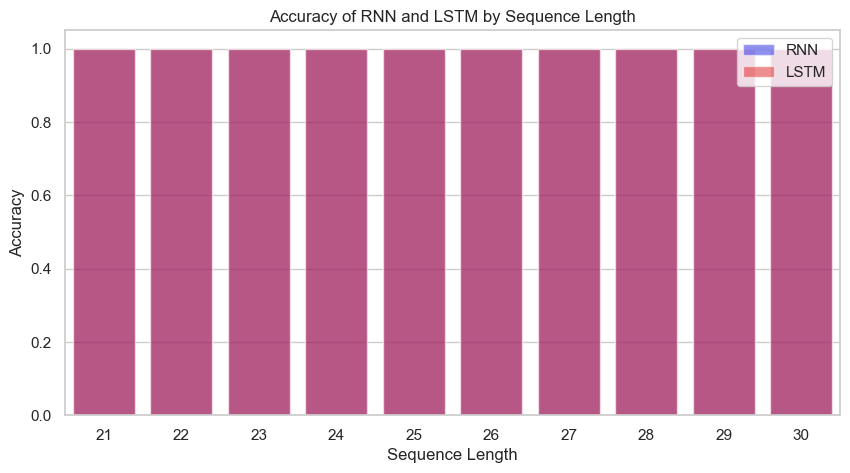

In [498]:

# Plot Accuracy scores agains eachother using seaborn in same plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(rnn_accuracy.keys()), y=list(rnn_accuracy.values()), color='blue', alpha=0.5, label='RNN')
sns.barplot(x=list(lstm_accuracy.keys()), y=list(lstm_accuracy.values()), color='red', alpha=0.5, label='LSTM')
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
plt.title('Accuracy of RNN and LSTM by Sequence Length')
plt.legend()
plt.show()